# Extract Results

In [1]:
import pandas as pd
from pathlib import Path 
import json
import numpy as np
import re

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def read_probing_result(checkpoint_dir, slurm_id=0):
    if slurm_id == 0:  # Find one
        ps = sorted(list(checkpoint_dir.glob("probe_results_*.jsonl")))
        if len(ps) == 0:
            raise ValueError(f"No probing results found in {checkpoint_dir.name}")
        else:
            p = ps[-1]
            #print ("Found {} in {}".format(p.name, checkpoint_dir.name))
    else:
        p = Path(checkpoint_dir, f"probe_results_{slurm_id}.jsonl")
    with open(p, "r") as f:
        lines = f.readlines()
    results = []
    for line in lines:
        results.append(json.loads(line))
    return results

def read_dg_result(checkpoint_dir):
    with open(Path(checkpoint_dir, "results.jsonl"), "r") as f:
        lines = f.readlines()
    results = []
    for line in lines:
        results.append(json.loads(line))
    return results

def decode_directory_name(name):
    # name is e.g., "SagNet_RotatedMNIST_testenv5"
    L = name.split("_")
    if len(L) == 3:
        alg_name, ds_name, testenv_ = L
    elif len(L) == 4:  # e.g., "IB_ERM_RotatedMNIST_testenv5"
        a1, a2, ds_name, testenv_ = L
        alg_name = f"{a1}_{a2}"
    testenv = int(re.split('(\d+)', testenv_)[-2])  # "testenv5" -> ["testenv", "5", ""]
    return alg_name, ds_name, testenv
configs_by_dataset = {
    "RotatedMNIST": {"n_env": 6, "n_probe": 5},
    "ColoredMNIST": {"n_env": 3, "n_probe": 5}
}

def collect_results(dataset="RotatedMNIST", base_dir="../checkpoints"):
    collected_results = {
        "algorithm": [],
        "dataset": [],
        "testenv": [],
        "dg_in_acc": [],
        "dg_out_acc": []
    }
    
    config = configs_by_dataset[dataset]
    n_env, n_probe = config["n_env"], config["n_probe"]
    
    for pi in range(n_probe):
        collected_results[f"probe_{pi}_in"] = []
        collected_results[f"probe_{pi}_out"] = []
    
    for p in Path(base_dir).glob(f"*{dataset}*"):
        if not p.is_dir():
            continue
            
        alg_name, ds_name, testenv = decode_directory_name(p.name)
        collected_results["algorithm"].append(alg_name)
        collected_results["dataset"].append(ds_name)
        collected_results["testenv"].append(testenv)
        
        p_results = read_probing_result(p)[-1]  # dict of scalars
        for pi in range(n_probe):
            probing_val = np.mean([p_results[f"probe_{pi}_env_{ei}_insplit"] 
                  for ei in range(n_env)])
            collected_results[f"probe_{pi}_in"].append(probing_val)
            probing_val = np.mean([p_results[f"probe_{pi}_env_{ei}_outsplit"] 
                  for ei in range(n_env)])
            collected_results[f"probe_{pi}_out"].append(probing_val)
        
        g_results = read_dg_result(p)[-1]  # dict of scalar
        collected_results["dg_in_acc"].append(g_results[f"env{testenv}_in_acc"])
        collected_results["dg_out_acc"].append(g_results[f"env{testenv}_out_acc"])
        
    return pd.DataFrame(collected_results)

df = collect_results("RotatedMNIST")
#df.to_csv("../reports/0415_RotatedMNIST_results.csv", index=False)

dfc = collect_results("ColoredMNIST")
#dfc.to_csv("../reports/0415_ColoredMNIST_results.csv", index=False)

In [3]:
# Average across the folds
df_mean = df.groupby(["algorithm"]).mean().reset_index()
dfc_mean = dfc.groupby(["algorithm"]).mean().reset_index()

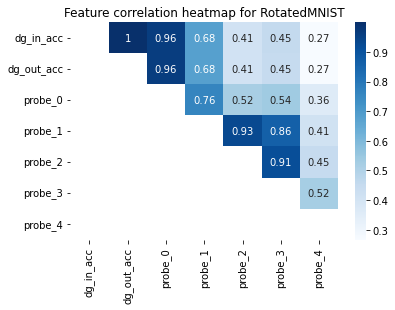

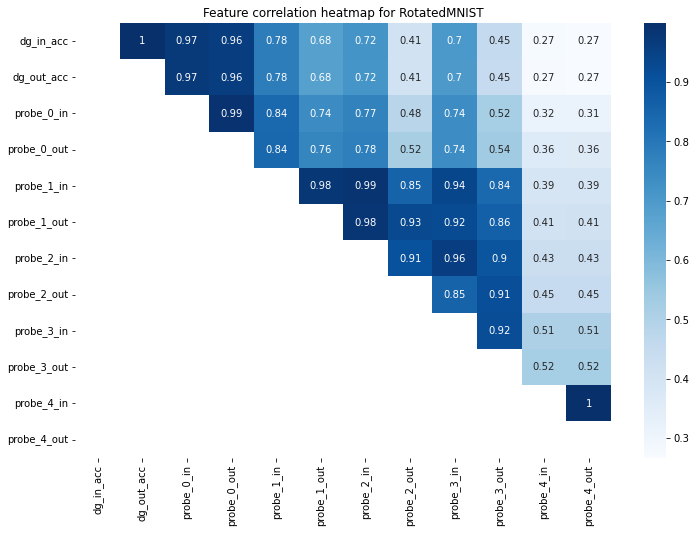

In [4]:
def make_correlation_plot(dfm, title, svg_filename, insplit_probe=True):
    if insplit_probe:
        plt.figure(figsize=(12, 8))
        dfm_ = dfm
    else:
        # Drop the "_in" columns
        dfm_ = dfm.loc[:, ~dfm.columns.str.endswith("_in")]
        # Rename the "probe_*_out" columns to "probe_*"
        dfm_ = dfm_.rename(columns=lambda x: re.sub("_out$", "", x))
    corr = dfm_.drop(columns=["testenv"]).corr()
    sns.heatmap(
        corr,
        cmap="Blues", annot=True, mask=np.tril(corr)
    )
    plt.title(title)
    plt.savefig(svg_filename)
    
make_correlation_plot(df_mean, 
                      "Feature correlation heatmap for RotatedMNIST", 
                      "../reports/0415/heatmap_rotatedmnist.svg", False) 
make_correlation_plot(df_mean, 
                      "Feature correlation heatmap for RotatedMNIST", 
                      "../reports/0415/heatmap_rotatedmnist_probes_in_out.svg", True) 

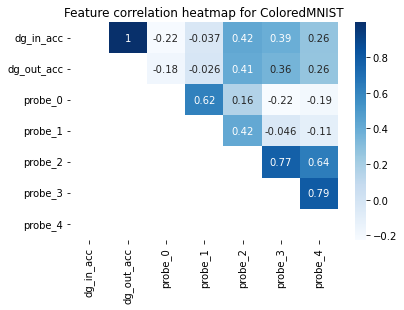

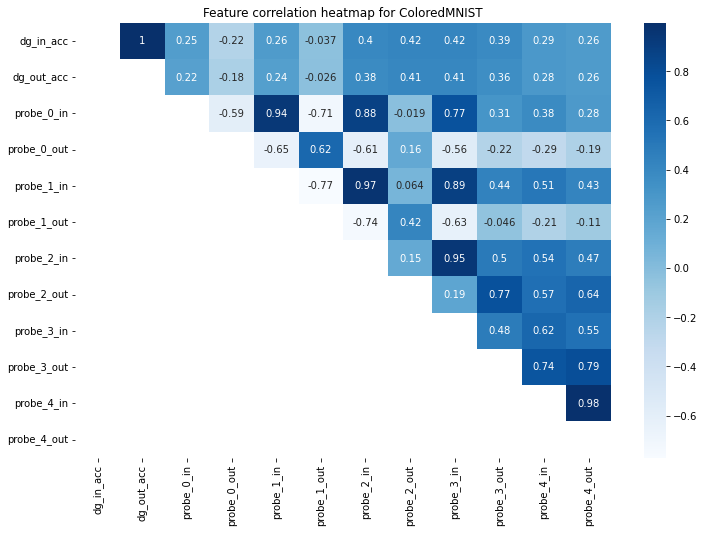

In [5]:
make_correlation_plot(dfc_mean, 
                      "Feature correlation heatmap for ColoredMNIST", 
                      "../reports/0415/heatmap_coloredmnist.svg", False) 
make_correlation_plot(dfc_mean, 
                      "Feature correlation heatmap for ColoredMNIST", 
                      "../reports/0415/heatmap_coloredmnist_probes_in_out.svg", True) 

**Interpretations up till now**  
- The DG performances using in-split and out-split portions are perfectly correlated, which is expected.  
- (For RotatedMNIST) As we go higher along the featurizer, the probing accuracies correlate less to the the DG performances.  
- (For ColoredMNIST) The above trend is not there.  
- How about using in-split instead of out-split? The correlations between different probes for in-split are higher for in-split, but again, this is not consistent for RotatedMNIST vs ColoredMNIST.

## ANOVA
The probing results of which layer best explain the DG performance?  
For RotatedMNIST: R2 is high. Lower layers are better.  
For ColoredMNIST: R2 is low. No layer is significant (p<.05 in ANOVA).  

In [6]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

/Users/zhuzi/miniforge3/envs/transformers4/lib/python3.9/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [7]:
def run_anova(dfm, target="dg_out_acc", num_probes=5):
    y = dfm[target]
    # Drop the "_in" columns
    dfm_ = dfm.loc[:, ~dfm.columns.str.endswith("_in")]
    # Rename the "probe_*_out" columns to "probe_*"
    dfm = dfm_.rename(columns=lambda x: re.sub("_out$", "", x))
    
    x_str = " + ".join([f"probe_{i}" for i in range(num_probes)])
    model = ols(f'{target} ~ {x_str}', data=dfm).fit()
    print(model.summary())
    
    table = sm.stats.anova_lm(model, typ=2)  # Type 2 Anova DataFrame
    print(table)
    
run_anova(df_mean)
run_anova(dfc_mean)

                            OLS Regression Results                            
Dep. Variable:             dg_out_acc   R-squared:                       0.947
Model:                            OLS   Adj. R-squared:                  0.931
Method:                 Least Squares   F-statistic:                     57.46
Date:                Sat, 16 Apr 2022   Prob (F-statistic):           1.18e-09
Time:                        19:20:24   Log-Likelihood:                 28.199
No. Observations:                  22   AIC:                            -44.40
Df Residuals:                      16   BIC:                            -37.85
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -27.4324      4.022     -6.820      0.0

## Leave-one-out predictability of probing features

In [8]:
from sklearn.model_selection import LeaveOneOut
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.metrics import mean_squared_error

In [9]:
def loocv_prediction_all_probes(dfm, target="dg_out_acc"):
    Y = dfm[target]
    
    # Drop the "_in" columns
    dfm_ = dfm.loc[:, ~dfm.columns.str.endswith("_in")]
    # Rename the "probe_*_out" columns to "probe_*"
    dfm = dfm_.rename(columns=lambda x: re.sub("_out", "", x))
    X = dfm.loc[:, dfm.columns.str.startswith("probe")]
    
    preds = []
    labels = []
    loo = LeaveOneOut()
    for tr_idx, test_idx in loo.split(X):
        Xtr, Ytr = X.loc[tr_idx, :], Y[tr_idx]
        Xtest, Ytest = X.loc[test_idx, :], Y[test_idx]
        
        model = LinearRegression()
        model.fit(Xtr, Ytr)
        pred = model.predict(Xtest)
        preds.append(pred[0])
        labels.append(Ytest.values[0])
    mse = mean_squared_error(labels, preds)
    rmse = np.sqrt(mse)

    print ("RMSE: {:.4f}".format(rmse))
    
loocv_prediction_all_probes(df_mean)
loocv_prediction_all_probes(dfc_mean)

RMSE: 0.1253
RMSE: 0.0494
